In [1]:
import ase.io
import spglib

# Read the structure from a file (replace 'structure.cif' with your file)
structure = ase.io.read('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/Au_lead.vasp')


# Convert the ASE atoms object to a spglib compatible format
cell = (
    structure.get_cell(),  # Lattice vectors
    structure.get_scaled_positions(),  # Atomic positions
    structure.get_atomic_numbers()  # Atomic numbers
)

# Get the conventional cell using spglib
standardized_cell = spglib.standardize_cell(cell, to_primitive=False, no_idealize=True)
standardized_cell2 = spglib.standardize_cell(standardized_cell, to_primitive=False, no_idealize=True)
# Create an ASE Atoms object from the standardized cell
conv_atoms = ase.Atoms(
    numbers=standardized_cell[2],
    scaled_positions=standardized_cell[1],
    cell=standardized_cell[0],
    pbc=True
)

# Print the conventional cell
print(conv_atoms)

ase.io.write('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/Au_lead_conv.vasp', conv_atoms)


Atoms(symbols='Au36', pbc=True, cell=[8.8188394545, 8.8188394545, 8.314432480000008])


In [2]:
import ase.io
import spglib
import numpy as np

# Read the structure from a file (replace 'structure.cif' with your file)
structure = ase.io.read('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/Au_lead_2PL.vasp')

# Extract the cell and atomic positions
cell = structure.get_cell()
positions = structure.get_positions()
atomic_numbers = structure.get_atomic_numbers()

# Extract lattice vectors and positions
a, b, c = cell
scaled_positions = structure.get_scaled_positions()

# Create a new cell with the z-direction fixed
fixed_z_cell = np.array([
    [a[0], a[1], 0],
    [b[0], b[1], 0],
    [0, 0, c[2]]
])

# Create a spglib-compatible cell tuple
spglib_cell = (fixed_z_cell, scaled_positions, atomic_numbers)

# Get the smallest cell using spglib
smallest_cell = spglib.standardize_cell(spglib_cell, to_primitive=True, no_idealize=False)

# Convert the smallest cell back to ASE Atoms object
smallest_cell_ase = ase.Atoms(
    numbers=smallest_cell[2],
    scaled_positions=smallest_cell[1],
    cell=smallest_cell[0],
    pbc=True
)

# Extract the reduced xy-plane lattice vectors and original z-direction
xy_cell = smallest_cell_ase.get_cell()
xy_cell[2] = cell[2]  # Keep the original z-direction

# Set the new cell with fixed z-direction
smallest_cell_ase.set_cell(xy_cell, scale_atoms=True)

# Print the new smallest periodic cell
print(smallest_cell_ase)


Atoms(symbols='Au36', pbc=True, cell=[8.8188394545, 8.8188394545, 16.628864960000016])


In [3]:
# Read the structure from a file (replace 'structure.cif' with your file)
import ase
from ase.build import sort
structure = ase.io.read('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/Au_lead_2PL.vasp')
cell = structure.get_cell()
positions = structure.get_positions()
atomic_numbers = structure.get_atomic_numbers()

bloch_factor = [6,6,1]
# Create a new cell with the z-direction fixed
fixed_z_cell = np.array([
    [cell[0][0]/bloch_factor[0], 0, 0],
    [0, cell[1][1]/bloch_factor[1], 0],
    [0, 0, cell[2][2]]
])

new_positions = []
new_atomic_numbers = []

delta = 1e-4
for ip,pos in enumerate(positions):
    if pos[0]<cell[0][0]/bloch_factor[0]-delta and pos[1]<cell[1][1]/bloch_factor[1]-delta:
        new_positions.append(pos)
        new_atomic_numbers.append(atomic_numbers[ip])


smallest_cell_ase = ase.Atoms(
    numbers=new_atomic_numbers,
    positions=new_positions,
    cell=fixed_z_cell,
    pbc=True
)

smallest_cell_ase = sort(smallest_cell_ase,tags=smallest_cell_ase.positions[:,0])
smallest_cell_ase = sort(smallest_cell_ase,tags=smallest_cell_ase.positions[:,1])
smallest_cell_ase = sort(smallest_cell_ase,tags=smallest_cell_ase.positions[:,2])


ase.io.write('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/Au_lead_small_2PLtest.vasp', smallest_cell_ase )

In [6]:
#思路
# 获得小电极的结构，用模型预测HR和HK，进行自能计算
from dptb.nn.build import build_model
from dptb.data import AtomicData, AtomicDataDict
import torch
from ase.io import read
import numpy as np
from dptb.nn.hr2hk import HR2HK

from bloch import Bloch


kp = [0,0,0]
bloch = Bloch(bloch_factor)
k_unfold = bloch.unfold_points(kp)


def remove_bonds_nonpbc(data,pbc,overlap):

    for ip,p in enumerate(pbc):
        if not p:
            mask = abs(data[AtomicDataDict.EDGE_CELL_SHIFT_KEY][:,ip])<1e-7
            data[AtomicDataDict.EDGE_CELL_SHIFT_KEY] = data[AtomicDataDict.EDGE_CELL_SHIFT_KEY][mask]
            data[AtomicDataDict.EDGE_INDEX_KEY] = data[AtomicDataDict.EDGE_INDEX_KEY][:,mask]
            data[AtomicDataDict.EDGE_FEATURES_KEY] = data[AtomicDataDict.EDGE_FEATURES_KEY][mask]
            if overlap:
                data[AtomicDataDict.EDGE_OVERLAP_KEY] = data[AtomicDataDict.EDGE_OVERLAP_KEY][mask]

model = build_model(checkpoint="/personal/DFTB/Au_Ag/Au_TS/nnsk_dftbint/checkpoint/nnsk.best.pth")
AtomicData_options={
        "r_max": 5.5,
        "pbc": True
    }


h2k = HR2HK(
            idp=model.idp, 
            edge_field=AtomicDataDict.EDGE_FEATURES_KEY, 
            node_field=AtomicDataDict.NODE_FEATURES_KEY, 
            out_field=AtomicDataDict.HAMILTONIAN_KEY, 
            dtype= model.dtype, 
            device='cpu'
            )
s2k = HR2HK(
    idp=model.idp, 
    overlap=True, 
    edge_field=AtomicDataDict.EDGE_OVERLAP_KEY, 
    node_field=AtomicDataDict.NODE_OVERLAP_KEY, 
    out_field=AtomicDataDict.OVERLAP_KEY, 
    dtype=model.dtype, 
    device='cpu'
    )


structure_leads = read('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/Au_lead_small_2PLtest.vasp')
# structure_leads = read('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/Au_lead_2PL.vasp')
from ase.build import sort
structure_leads = sort(structure_leads,tags=structure_leads.positions[:,0])
structure_leads = sort(structure_leads,tags=structure_leads.positions[:,1])
structure_leads = sort(structure_leads,tags=structure_leads.positions[:,2])

# kpoints = np.array([[0,0,0]])
kpoints = k_unfold


lead_data = AtomicData.from_ase(structure_leads, **AtomicData_options)
lead_data = AtomicData.to_AtomicDataDict(lead_data.to(torch.device('cpu')))
lead_data = model.idp(lead_data)
lead_data[AtomicDataDict.KPOINT_KEY] = \
    torch.nested.as_nested_tensor([torch.as_tensor(kpoints, dtype=model.dtype, device='cpu')])
lead_data = model(lead_data)   
pbc = [True,True, False]
overlap = True
remove_bonds_nonpbc(lead_data,pbc,overlap=overlap)


lead_data = h2k(lead_data)
HK_lead = lead_data[AtomicDataDict.HAMILTONIAN_KEY]
if overlap: 
    lead_data = s2k(lead_data)
    S_lead = lead_data[AtomicDataDict.OVERLAP_KEY]
else:
    S_lead = torch.eye(HK_lead.shape[1], dtype=model.dtype, device='cpu').unsqueeze(0).repeat(HK_lead.shape[0], 1, 1)


nL = int(HK_lead.shape[1] / 2)
HLL, SLL = HK_lead[:, :nL, nL:], S_lead[:, :nL, nL:] # H_{L_first2L_second}
hL, sL = HK_lead[:,:nL,:nL], S_lead[:,:nL,:nL] # lead hamiltonian in one principal layer
HL = hL
SL = sL


HS_leads = {}
HS_leads["kpoints"] = kpoints
h_factor=1
HS_leads.update({
    "HL":HL.cdouble()*h_factor, 
    "SL":SL.cdouble(), 
    "HDL":HL.cdouble()*h_factor,
    "SDL":SL.cdouble(),
    "HLL":HLL.cdouble()*h_factor, 
    "SLL":SLL.cdouble()
    }) 
torch.save(HS_leads, '/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/HS_lead_small.pth')
# torch.save(HS_leads, '/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/HS_lead.pth')

In [7]:
import torch
HS_leads = torch.load('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/HS_lead_small.pth')
HS_leads['HL'].shape
HS_leads['kpoints'].shape

(36, 3)

In [8]:
from dptb.negf.surface_green import selfEnergy
import torch

HS_leads = torch.load('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/HS_lead_small.pth')

# hL = HS_leads['HL'][0]
# hLL = HS_leads['HLL'][0]
# sL = HS_leads['SL'][0]
# sLL = HS_leads['SLL'][0]
ee = 2

Sig_list = []
SGF_list = []

# self-energy and surface Green's function
for i in range(HS_leads['HL'].shape[0]):
    hL = HS_leads['HL'][i]
    hLL = HS_leads['HLL'][i]
    sL = HS_leads['SL'][i]
    sLL = HS_leads['SLL'][i]
    Sig, SGF = selfEnergy(hL, hLL, sL, sLL, ee, 
            hDL=None, sDL=None, etaLead=1e-8, Bulk=False, 
            chemiPot=0.0, dtype=torch.complex128, device='cpu', method='Lopez-Sancho')
    Sig_list.append(Sig)
    SGF_list.append(SGF)
print('small lead self-energy is ready')


HS_leads = torch.load('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/HS_lead.pth')
hL = HS_leads['HL'][0]
hLL = HS_leads['HLL'][0]
sL = HS_leads['SL'][0]
sLL = HS_leads['SLL'][0]
Sig_all, SGF_all = selfEnergy(hL, hLL, sL, sLL, ee, 
            hDL=None, sDL=None, etaLead=1e-8, Bulk=False, 
            chemiPot=0.0, dtype=torch.complex128, device='cpu', method='Lopez-Sancho')


small lead self-energy is ready


In [9]:
Sig_all.shape
Sig_list[0].shape

torch.Size([36, 36])

In [10]:
small_struct = read('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/Au_lead_small.vasp')
small_struct.positions

array([[0.        , 0.        , 0.        ],
       [0.        , 2.93961903, 0.        ],
       [2.93961903, 0.        , 0.        ],
       [2.93961903, 2.93961903, 0.        ],
       [1.46980599, 1.46980599, 2.07854976],
       [1.46980599, 4.40941973, 2.07854976],
       [4.40941973, 1.46980599, 2.07854976],
       [4.40941973, 4.40941973, 2.07854976],
       [0.        , 0.        , 4.15709952],
       [0.        , 2.93961903, 4.15709952],
       [2.93961903, 0.        , 4.15709952],
       [2.93961903, 2.93961903, 4.15709952],
       [1.46980599, 1.46980599, 6.23588272],
       [1.46980599, 4.40941973, 6.23588272],
       [4.40941973, 1.46980599, 6.23588272],
       [4.40941973, 4.40941973, 6.23588272]])

In [12]:
from ase.io import read
from ase.build import sort

# one Principal layer
small_struct = read('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/Au_lead_smalltest.vasp')
small_struct = sort(small_struct,tags=small_struct.positions[:,0])
small_struct = sort(small_struct,tags=small_struct.positions[:,1])
small_struct = sort(small_struct,tags=small_struct.positions[:,2])
small_cell = small_struct.get_cell()

Sig_k_list = []
origin_pos = []
all_pos = []
atom_orb = 9


R_list = []
for rz in range(bloch_factor[2]):
    for ry in range(bloch_factor[1]):
        for rx in range(bloch_factor[0]):     
            R = torch.tensor([rx,ry,rz],dtype=torch.float64)
            R_list.append(R)
            for id in range(len(small_struct)):
                pos = torch.tensor(small_struct.positions[id]) + R[0]*small_cell[0] + R[1]*small_cell[1] + R[2]*small_cell[2]
                origin_pos.append(pos)
            
origin_pos = torch.stack(origin_pos)
all_struct = read('/personal/DeepTB/dptb_Zjj/DeePTB/dptb/negf/bloch_files/Au_lead.vasp')
assert len(all_struct) == len(origin_pos)
sorted_indices = np.lexsort((origin_pos.numpy()[:, 0], origin_pos.numpy()[:, 1], origin_pos.numpy()[:, 2]))

basis_norb = torch.ones(int(origin_pos.shape[0]),dtype=torch.int64)*atom_orb 
origin_basis_index = torch.cumsum(basis_norb,0)
sorted_basis_indices = []
for ia in sorted_indices:
    for k in range(atom_orb):
        sorted_basis_indices.append(origin_basis_index[ia]-atom_orb+k)
        
sorted_basis_indices = torch.stack(sorted_basis_indices)

for ik,k in enumerate(k_unfold):
    k = torch.tensor(k)
    phase_factor_list = []
    m_size = bloch_factor[2]*bloch_factor[1]*bloch_factor[0]
    phase_factor_m = torch.zeros([m_size,m_size],dtype=torch.complex128)
    for i in range(m_size):
        for j in range(m_size):
            if i == j:
                phase_factor_m[i,j] = 1
            else:
                phase_factor_m[i,j] = torch.exp(torch.tensor(1j)*2*torch.pi*torch.dot(R_list[j]-R_list[i],k))  

    Sig_k_list.append(torch.kron(phase_factor_m,Sig_list[ik]))

Sig_sumup = torch.sum(torch.stack(Sig_k_list),dim=0)/len(Sig_k_list)
Sig_sumup_sorted = Sig_sumup[sorted_basis_indices,:][:,sorted_basis_indices]


In [84]:
len(R_list)

36

In [85]:
abs(Sig_sumup_sorted[-10:,-10:].real-Sig_all[-10:,-10:].real).max()

tensor(1.7361e-05, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [86]:
abs(Sig_all-Sig_sumup_sorted).max()

tensor(3.3628e-05, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [87]:
#在Nx=72时误差显著放大，代码里显然有bug
Nx=73
abs(Sig_all[:Nx,:Nx]-Sig_sumup_sorted[:Nx,:Nx]).max()
# Sig_all[17:Nx,17:Nx]-Sig_sumup[17:Nx,17:Nx]

tensor(3.5893e-14, dtype=torch.float64, grad_fn=<MaxBackward1>)

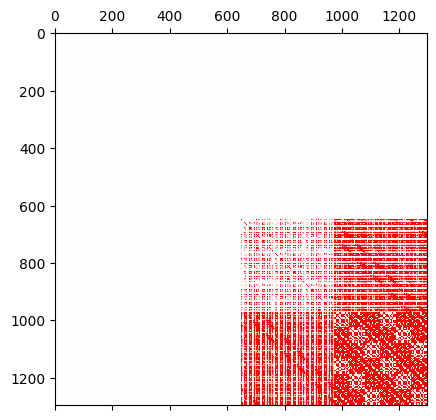

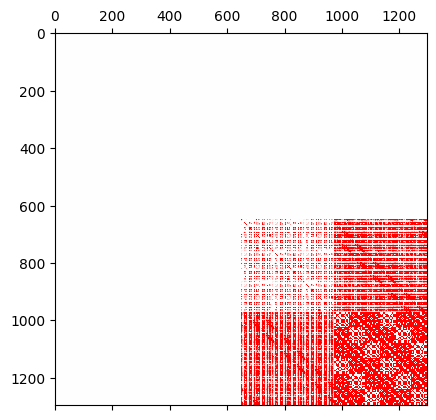

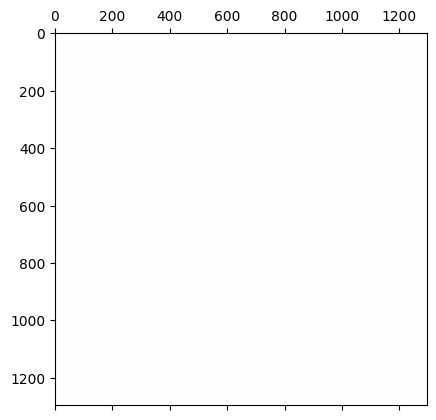

In [13]:
import matplotlib.pyplot as plt
diff_sig = Sig_all - Sig_sumup_sorted
# diff_sig = Sig_sumup_sorted[-18:,-18:].real-Sig_all[-18:,-18:].real
plt.matshow(abs(Sig_sumup_sorted.detach().numpy()),cmap='bwr',vmax=0.005,vmin=-0.005)
plt.matshow(abs(Sig_all.detach().numpy()),cmap='bwr',vmax=0.005,vmin=-0.005)
plt.matshow(abs(diff_sig.detach().numpy()),cmap='bwr',vmax=0.05,vmin=-0.05)

#部分对角元上都没有问题，说明可能是相位设置出现了问题
#所有对角块总能对上
#调整默认相位convention，可以使更多格子对上，但仍有较多非对角元无法对上
#应该还是轨道顺序的问题，自能矩阵中每个原子的onsite block是一致的，而原子-原子间的相互作用有问题
##要过一遍自能计算的流程，将原子的轨道顺序check一下

In [126]:
# a = Sig_sumup_sorted[-9:,-18:-9].flatten()[14]
for idj,j in enumerate(Sig_sumup_sorted.flatten().detach().numpy()[::-1]):
    pair = False
    for idi,i in enumerate(Sig_all.flatten().detach().numpy()[::-1]):
            if abs(i-j)<1e-4:
                pair = True
                break
    if pair == False:
        print(idj)
        print(j)
